In [ ]:
!pip install equinox
!pip install signax

In [1]:
!git clone https://github.com/Faust-jiang/sigformer.git

fatal: destination path 'sigformer' already exists and is not an empty directory.


In [ ]:
import os
import pickle

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
from sigformer.hedger import DeepHedger, SigHedger
from sigformer.hedger.delta_hedger import HestonDeltaHedger, RBergomiDeltaHedger  # noqa
from sigformer.instruments.derivative import EuropeanOption, VarianceSwap
from sigformer.instruments.primary import RoughBergomiStock
from sigformer.loss import BaseCriterion
from tqdm import tqdm
from pathlib import Path

### Load data

In [ ]:
root_path = '/Users/fjiang/Downloads/data/spx/'
opt_path ='/Users/fjiang/Downloads/spx_eod/'
spx_file = "SP500.csv"
vix_file = "VIXCLS.csv"
calibrated_file = "calibrated.pkl"
os.getcwd()

'/Users/fjiang/sigformer'

In [ ]:
# VIX
df_vix = pd.read_csv(os.path.join(root_path, vix_file))
# SPX
df_spx = pd.read_csv(os.path.join(root_path, spx_file))
df_optprice= pd.read_csv(os.path.join(opt_path, "spx_eod_202203.txt"))


In [ ]:
df_spx.head()

,DATE,SP500
0,2022-01-03,4796.56
1,2022-01-04,4793.54
2,2022-01-05,4700.58
3,2022-01-06,4696.05
4,2022-01-07,4677.03


In [ ]:
df_vix.head()

,DATE,VIXCLS
0,2022-01-03,16.6
1,2022-01-04,16.91
2,2022-01-05,19.73
3,2022-01-06,19.61
4,2022-01-07,18.76


In [ ]:
df_vix = df_vix.rename(columns={"VIXCLS": "VIX"})
df_spx = df_spx.rename(columns={"SP500": "SPX"})

df_vix.DATE = pd.to_datetime(df_vix.DATE)
df_vix.VIX = pd.to_numeric(df_vix.VIX, errors="coerce")

df_spx.DATE = pd.to_datetime(df_spx.DATE)
df_spx.SPX = pd.to_numeric(df_spx.SPX, errors="coerce")

In [ ]:
df_spx_vix = pd.merge(df_spx, df_vix)

## Hedging given the calibrated parameters

In [ ]:
with open(os.path.join(root_path, calibrated_file), "rb") as f:
    calibrated_params = pickle.load(f)

In [ ]:
# SigHedger
signature_dim = 6
n_attn_heads = 12
n_attn_blocks = 5

# traing
n_train_paths = 1000
n_valid_paths = 1000
n_epochs = 1000
lr = 1e-4

n_test_paths = 5_000
seed = 123
inputs = ["LogMoneyness", "Volatility"]
T=30/365

In [ ]:
key = jrandom.PRNGKey(seed)
model_key, train_key, valid_key, test_key = jrandom.split(key, 4)

In [ ]:
class VIX(VarianceSwap):
    def __init__(
        self, underlier, maturity: float = 45.0 / 356, strike: float = 0.04
    ) -> None:
        super().__init__(underlier, maturity, strike)

    def price(self, input):
        VIX = jnp.sqrt(input["forward_variance"])
        standard_v= (VIX-jnp.mean(VIX))/jnp.std(VIX)
        return standard_v

In [ ]:
class QuadraticLoss(BaseCriterion):

    p0: float

    def __init__(self, p0) -> None:
        super().__init__()
        self.p0 = p0

    def __call__(self, input, target):
        return jnp.mean(jnp.square(input - target + self.p0))

In [ ]:
p_0=[] #price of derivative
for month in range(1, 13):
    params = calibrated_params[month]

    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    forward_variance = ForwardVariance(stock, maturity=T)
    hedge = [derivative, forward_variance]

    payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
    payoff = jax.vmap(payoff_fn)(jrandom.split(test_key, n_test_paths))
    p0 = jnp.mean(payoff)
    p_0.append(p0)
    loss_fn = QuadraticLoss(p0=p0)
    print(f"p0: {p0.item():.3f}")

    model = SigHedger(
            derivative=derivative,
            inputs=inputs,
            hedge=hedge,
            criterion=loss_fn,
            signature_dim=signature_dim,
            n_attn_heads=n_attn_heads,
            n_attn_blocks=n_attn_blocks,
            order=1,
            #randomness = hurst+ rho**2,
            rng_key=model_key,
        )

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))


    @eqx.filter_value_and_grad
    def compute_loss(model: SigHedger, n_simulate_paths, rng_key):
        return model.compute_loss(
            init_state=init_state,
            n_paths=n_simulate_paths,
            rng_key=rng_key,
        )

    @eqx.filter_jit
    def make_step(model: SigHedger, opt_state, n_simulate_paths, rng_key):

        loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    valid_keys = jrandom.split(valid_key, n_valid_paths)
    valid_data = jax.vmap(
        lambda key: derivative.simulate(rng_key=key, init_state=init_state)
    )(valid_keys)

    @eqx.filter_jit
    def validate(model: SigHedger, valid_data):
        portfolio, payoff = model.compute_pnl(
            rng_key=None,
            n_paths=n_valid_paths,
            simulated_data=valid_data,
            return_portfolio_and_payoff=True,
        )
        return model.criterion(portfolio, payoff)

    progress = tqdm(range(n_epochs), desc=f"Month={month}")
    for i in progress:

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            n_simulate_paths=n_train_paths,
            rng_key=jrandom.fold_in(train_key, i),
        )
        if i % 20 == 0:
            valid_model = eqx.tree_inference(model, True)

            # compute validate loss
            valid_loss = validate(valid_model, valid_data)

    model = eqx.tree_inference(model, True)
    model_file = f"../checkpoint/model_month_{month}.eqx"
    #model_file.parent.mkdir(parents=True, exist_ok=True)
    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    eqx.tree_serialise_leaves(model_file, model)



Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =4796.56
p0: 22.547


NameError: name 'model_2' is not defined

In [ ]:
p_0=[] #price of derivative
for month in range(1, 13):
    params = calibrated_params[month]

    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]/50

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    vix = VIX(stock)
    hedge = [derivative, vix]

    payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
    payoff = jax.vmap(payoff_fn)(jrandom.split(test_key, n_test_paths))
    p0 = jnp.mean(payoff)
    p_0.append(p0)
    loss_fn = QuadraticLoss(p0=p0)
    print(f"p0: {p0.item():.3f}")

    model = SigHedger(
            derivative=derivative,
            inputs=inputs,
            hedge=hedge,
            criterion=loss_fn,
            signature_dim=signature_dim,
            n_attn_heads=n_attn_heads,
            n_attn_blocks=n_attn_blocks,
            order=1,
            #randomness = hurst+ rho**2,
            rng_key=model_key,
        )


    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))


    @eqx.filter_value_and_grad
    def compute_loss(model: SigHedger, n_simulate_paths, rng_key):
        return model.compute_loss(
            init_state=init_state,
            n_paths=n_simulate_paths,
            rng_key=rng_key,
        )

    @eqx.filter_jit
    def make_step(model: SigHedger, opt_state, n_simulate_paths, rng_key):

        loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    valid_keys = jrandom.split(valid_key, n_valid_paths)
    valid_data = jax.vmap(
        lambda key: derivative.simulate(rng_key=key, init_state=init_state)
    )(valid_keys)

    @eqx.filter_jit
    def validate(model: SigHedger, valid_data):
        portfolio, payoff = model.compute_pnl(
            rng_key=None,
            n_paths=n_valid_paths,
            simulated_data=valid_data,
            return_portfolio_and_payoff=True,
        )
        return model.criterion(portfolio, payoff)

    progress = tqdm(range(n_epochs), desc=f"Month={month}")
    for i in progress:

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            n_simulate_paths=n_train_paths,
            rng_key=jrandom.fold_in(train_key, i),
        )

        if i % 20 == 0:
            valid_model = eqx.tree_inference(model, True)

            # compute validate loss
            valid_loss = validate(valid_model, valid_data)

    model = eqx.tree_inference(model, True)
    model_file = f"../checkpoint/model_month_{month}.eqx"
    #model_file.parent.mkdir(parents=True, exist_ok=True)
    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    eqx.tree_serialise_leaves(model_file, model)


Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =95.9312
p0: 0.451


Month=1: 100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =90.9308
p0: 0.427


Month=2: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =86.1252
p0: 2.964


Month=3: 100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =90.9172
p0: 0.433


Month=4: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =83.1076
p0: 2.112


Month=5: 100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =82.02459999999999
p0: 2.940


Month=6: 100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =76.50659999999999
p0: 0.358


Month=7: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =82.3726
p0: 1.339


Month=8: 100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =79.337
p0: 0.372


Month=9: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =73.5686
p0: 0.486


Month=10: 100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =77.122
p0: 1.890


Month=11: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =81.5314
p0: 0.388


Month=12: 100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


In [ ]:
# make dummy model
#loss_fn = QuadraticLoss(p0=22)
stock = RoughBergomiStock(
    hurst=0.1,
    rho=-0.9,
    xi=0.235**2,
    eta=1.9,
    cost=0,
    dt=1.0 / 365,
    forward_offset=15.0 / 365,
)
init_state = (100, stock.xi, None)

derivative = EuropeanOption(
    underlier=stock,
    call=True,
    strike=100,
    maturity=30.0 / 365,
)

vix = VIX(stock, maturity=30.0 / 365)
hedge = [derivative, vix]

model = SigHedger(
    derivative=derivative,
            inputs=inputs,
            hedge=hedge,
            criterion=loss_fn,
            signature_dim=6,
            n_attn_heads=n_attn_heads,
            n_attn_blocks=n_attn_blocks,
            order=1,
            #randomness= rho**2+hurst,
            rng_key=model_key,
)

In [ ]:
pnl_evolutions = {}
pnl_sig={}

for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()/50   #make consistent of magnitude
    vix = df_month["VIX"].to_numpy()
    K = spx[0]
    moneyness = spx / K
    var_swap = vix / 100

    log_moneyness = jnp.log(jnp.asarray(moneyness, dtype=jnp.float32))
    var_swap = jnp.asarray(var_swap)
    logmoneyness_varswap= jnp.stack([log_moneyness, var_swap], axis=1)
    portfolio = jnp.stack([moneyness, var_swap], axis=1)
    model_file = f"../checkpoint/model_month_{month}.eqx"
    model = eqx.tree_deserialise_leaves(model_file, model)

    unit = model.model(logmoneyness_varswap, key=None)  #see function compute_hedge the input is log moneyness and volatility
    #but the trading strategies are units of spx and vix

    # compute

    payoff = (spx[-1]/K -1) * (spx[-1]/K -1 > 0)
    output = unit[:-1] * jnp.diff(portfolio, axis=0)

    output = jnp.sum(output, axis=-1)
    output = jnp.cumsum(output, axis=0) + p_0[month-1]/K


    output=output.at[-1].set(output[-1]- payoff)

    pnl_evolutions[month] = np.array(output)


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]


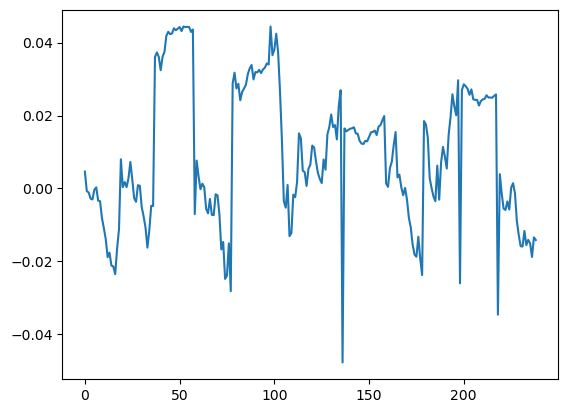

In [ ]:
#with open('pnlsig.pkl', 'wb') as f:
 #   pickle.dump(pnl_sig, f)
with open('pnlsig.pkl', 'rb') as f:
    loaded_sigpl= pickle.load(f)
plt.plot(np.concatenate(list(loaded_sigpl.values())))


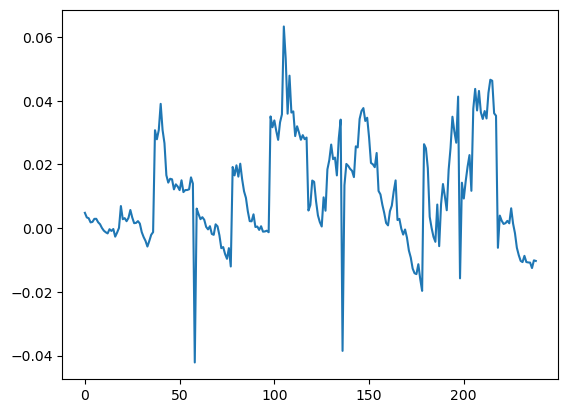

In [ ]:
#plt.plot(np.concatenate(list(pnl_evolutions.values())))

#with open('pnl_evolutions', 'wb') as f:
#   pickle.dump(pnl_evolutions, f)
with open('pnl_evolutions', 'rb') as f:
    loaded_pl= pickle.load(f)
plt.plot(np.concatenate(list(loaded_pl.values())))

### Deep hedging

In [ ]:
variance=[]
for month in range(1, 13):
    params = calibrated_params[month]

    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]/50

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    #variance.append(stock.simulate(,init_state= init_state)['variance'])

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    vix = VIX(stock)
    hedge = [derivative, vix]

    payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
    payoff = jax.vmap(payoff_fn)(jrandom.split(test_key, n_test_paths))
    p0 = jnp.mean(payoff)
    loss_fn = QuadraticLoss(p0=p0)
    print(f"p0: {p0.item():.3f}")

    model = DeepHedger(
        derivative=derivative,
        inputs=inputs,
        hedge=hedge,
        criterion=QuadraticLoss(p0=p0),
        recur_type="Recur",
        rng_key=model_key,
    )

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_value_and_grad
    def compute_loss(model: DeepHedger, n_simulate_paths, rng_key):  # noqa
        return model.compute_loss(
            init_state=init_state,
            n_paths=n_simulate_paths,
            rng_key=rng_key,
        )

    @eqx.filter_jit
    def make_step(model: DeepHedger, opt_state, n_simulate_paths, rng_key):  # noqa

        loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    valid_keys = jrandom.split(valid_key, n_valid_paths)
    valid_data = jax.vmap(
        lambda key: derivative.simulate(rng_key=key, init_state=init_state)
    )(valid_keys)

    @eqx.filter_jit
    def validate(model: SigHedger, valid_data):
        portfolio, payoff = model.compute_pnl(
            rng_key=None,
            n_paths=n_valid_paths,
            simulated_data=valid_data,
            return_portfolio_and_payoff=True,
        )
        return model.criterion(portfolio, payoff)

    progress = tqdm(range(n_epochs * 3), desc=f"Month={month}")  #
    for i in progress:

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            n_simulate_paths=n_train_paths,
            rng_key=jrandom.fold_in(train_key, i),
        )

        if i % 20 == 0:
            valid_model = eqx.tree_inference(model, True)

            # compute validate loss
            valid_loss = validate(valid_model, valid_data)

    model = eqx.tree_inference(model, True)
    model_file = f"../checkpoint/deephedger_month_{month}.eqx"
    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    eqx.tree_serialise_leaves(model_file, model)

Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =95.9312
p0: 0.451


Month=1: 100%|██████████| 3000/3000 [04:16<00:00, 11.72it/s]


Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =90.9308
p0: 0.427


Month=2: 100%|██████████| 3000/3000 [04:14<00:00, 11.77it/s]


Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =86.1252
p0: 2.964


Month=3: 100%|██████████| 3000/3000 [04:21<00:00, 11.47it/s]


Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =90.9172
p0: 0.433


Month=4: 100%|██████████| 3000/3000 [04:21<00:00, 11.49it/s]


Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =83.1076
p0: 2.112


Month=5: 100%|██████████| 3000/3000 [04:16<00:00, 11.68it/s]


Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =82.02459999999999
p0: 2.940


Month=6: 100%|██████████| 3000/3000 [04:20<00:00, 11.51it/s]


Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =76.50659999999999
p0: 0.358


Month=7: 100%|██████████| 3000/3000 [04:09<00:00, 12.02it/s]


Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =82.3726
p0: 1.339


Month=8: 100%|██████████| 3000/3000 [04:13<00:00, 11.85it/s]


Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =79.337
p0: 0.372


Month=9: 100%|██████████| 3000/3000 [04:08<00:00, 12.08it/s]


Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =73.5686
p0: 0.486


Month=10: 100%|██████████| 3000/3000 [04:02<00:00, 12.38it/s]


Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =77.122
p0: 1.890


Month=11: 100%|██████████| 3000/3000 [04:02<00:00, 12.35it/s]


Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =81.5314
p0: 0.388


Month=12: 100%|██████████| 3000/3000 [03:59<00:00, 12.54it/s]


In [ ]:
model = DeepHedger(
    derivative=derivative,
    inputs=inputs,
    hedge=hedge,
    recur_type="Recur",
    rng_key=model_key,
)
deephedger_pnl_evolutions = {}
p_0=[x/50 for x in p_0]
for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()/50
    vix = df_month["VIX"].to_numpy()
    K = spx[0]
    moneyness = spx / K
    var_swap = vix / 100
    log_moneyness = jnp.log(jnp.asarray(moneyness, dtype=jnp.float32))
    portfolio = jnp.stack([moneyness, var_swap], axis=1)
    var_swap = jnp.asarray(var_swap)
    log_moneyness_var_swap = jnp.stack([moneyness, var_swap], axis=1)
    model_file = f"../checkpoint/deephedger_month_{month}.eqx"
    model = eqx.tree_deserialise_leaves(model_file, model)
    unit = model.compute_hedge(
        simulated_data={
            "spot": jnp.array(spx)[None, ...],
            "variance": jnp.array(var_swap**2)[None, ...],
        },
        key=None,
    )

    payoff = (spx[-1]/K -1) * (spx[-1]/K -1 > 0)

    unit = unit[0, ...]
    print(unit.shape)
    # compute

    output = unit[:-1] * jnp.diff(portfolio, axis=0)
    output = jnp.sum(output, axis=-1)
    output = jnp.cumsum(output, axis=0)+p_0[month-1]/K
    output=output.at[-1].set(output[-1]- payoff)
    deephedger_pnl_evolutions[month] = np.array(output)

 33%|███▎      | 4/12 [00:00<00:00, 14.75it/s]

(20, 2)
(19, 2)
(23, 2)
(20, 2)


 67%|██████▋   | 8/12 [00:00<00:00, 15.15it/s]

(21, 2)
(21, 2)
(20, 2)
(23, 2)


100%|██████████| 12/12 [00:00<00:00, 15.21it/s]

(21, 2)
(21, 2)
(21, 2)
(21, 2)


100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


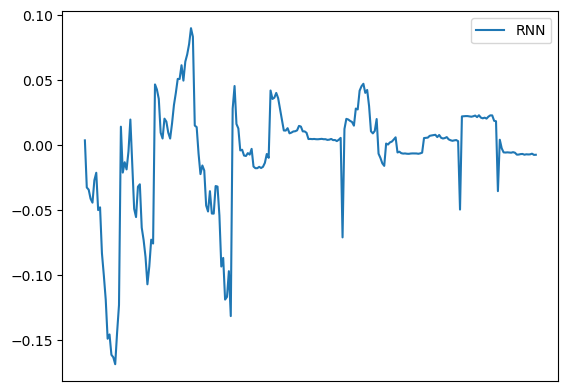

In [ ]:
plt.plot(np.concatenate(list(deephedger_pnl_evolutions.values())), label="RNN")
plt.xticks([])
plt.legend()
#with open('pnl_rnn.pkl', 'wb') as f:
 #  pickle.dump(deephedger_pnl_evolutions, f)

In [ ]:
df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()

In [ ]:
import matplotlib as mpl


mpl.rc("figure", dpi=300)
mpl.rc("font", family="Serif", serif=["Times", "Palatino", "serif"], size=18)
mpl.rc("axes", labelsize=10)
mpl.rc("axes", titlesize=12)
mpl.rc("xtick", labelsize=10)
mpl.rc("ytick", labelsize=10)

# Adjust the linewidths for lines and borders
mpl.rc("lines", linewidth=1)
mpl.rc("patch", linewidth=1)

# Customize the grid appearance
mpl.rc("grid", linewidth=0.5)
mpl.rc("grid", linestyle="--")
mpl.rc("grid", alpha=0.7)

# Set the legend font size and frame properties
mpl.rc("legend", fontsize=8)
mpl.rc("legend", frameon=True)
mpl.rc("legend", framealpha=0.7)
mpl.rc("legend", facecolor="white")

In [ ]:
spx_2022 = []

for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()
    spx_2022.append(spx)

spx_2022 = np.concatenate(spx_2022)

100%|██████████| 12/12 [00:00<00:00, 849.87it/s]


100%|██████████| 12/12 [00:00<00:00, 270.71it/s]


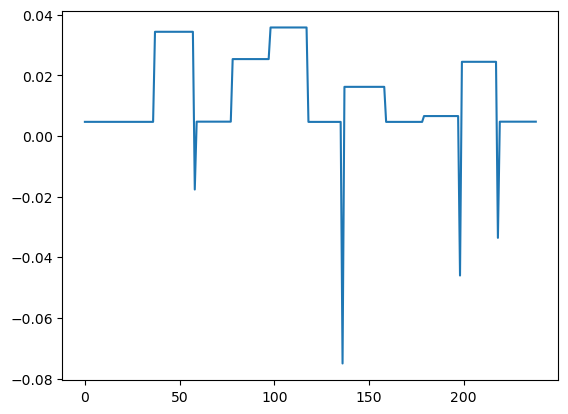

In [ ]:
#no hedge
no_evolutions={}

for month in tqdm(range(1, 13)):
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]/50



    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()/50
    output_shape=jnp.shape( jnp.diff(spx))
    payoff = (spx[-1]/K -1) * (spx[-1]/K -1 > 0)

    output = jnp.zeros(output_shape)
    output=output.at[0].set(output[0]+p_0[month-1]/K)
    output  = jnp.cumsum(output, axis=0)
    output=output.at[-1].set(output[-1]- payoff)
    no_evolutions[month] = np.array(output)


#with open('nono.pkl', 'wb') as f:
 #   pickle.dump(no_evolutions, f)
#with open('nono.pkl', 'rb') as f:
 #   no_evolutions= pickle.load(f)
plt.plot(np.concatenate(list(no_evolutions.values())))

### Perfect Hedge

In [ ]:
delta_pnl_evolutions = {}
for month in tqdm(range(1, 13)):

    params = calibrated_params[month]
    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]/50

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()/50
    vix = df_month["VIX"].to_numpy()
    K = spx[0]
    moneyness = spx / K
    var_swap = vix / 100

    delta_hedger = RBergomiDeltaHedger(derivative)
    unit = delta_hedger.compute_hedge(
        simulated_data={
            "spot": jnp.array(spx)[None, ...],
            "variance": jnp.array(var_swap**2)[None, ...],
            "forward_variance": jnp.array(var_swap**2)[None, ...],
        },
        key=jrandom.PRNGKey(0),
    )
    unit = unit[0, ...]
    portfolio = jnp.stack([moneyness, var_swap**2], axis=1)
    #print(unit.shape)

    payoff = (spx[-1]/K -1) * (spx[-1]/K -1 > 0)
    # compute
    output = unit[:-1] * jnp.diff(portfolio, axis=0)
    output = jnp.sum(output, axis=-1)

    output = jnp.cumsum(output, axis=0)+p_0[month-1]/K
    output=output.at[-1].set(output[-1]- payoff)
    delta_pnl_evolutions[month] = np.array(output)

  0%|          | 0/12 [00:00<?, ?it/s]

Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =95.9312



%|          | 0/19 [00:00<?, ?it/s]
%|▌         | 1/19 [00:00<00:10,  1.69it/s]
%|█         | 2/19 [00:01<00:09,  1.74it/s]
%|█▌        | 3/19 [00:01<00:08,  1.79it/s]
%|██        | 4/19 [00:02<00:08,  1.77it/s]
%|██▋       | 5/19 [00:02<00:08,  1.63it/s]
%|███▏      | 6/19 [00:03<00:08,  1.56it/s]
%|███▋      | 7/19 [00:04<00:10,  1.17it/s]
%|████▏     | 8/19 [00:05<00:09,  1.12it/s]
%|████▋     | 9/19 [00:07<00:11,  1.10s/it]
%|█████▎    | 10/19 [00:09<00:11,  1.31s/it]
%|█████▊    | 11/19 [00:10<00:11,  1.43s/it]
%|██████▎   | 12/19 [00:12<00:10,  1.47s/it]
%|██████▊   | 13/19 [00:13<00:08,  1.38s/it]
%|███████▎  | 14/19 [00:14<00:06,  1.28s/it]
%|███████▉  | 15/19 [00:15<00:04,  1.17s/it]
%|████████▍ | 16/19 [00:16<00:03,  1.05s/it]
%|████████▉ | 17/19 [00:16<00:01,  1.11it/s]
%|█████████▍| 18/19 [00:17<00:00,  1.26it/s]
  8%|▊         | 1/12 [00:18<03:20, 18.27s/it]

Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =90.9308



%|          | 0/18 [00:00<?, ?it/s]
%|▌         | 1/18 [00:00<00:08,  1.91it/s]
%|█         | 2/18 [00:01<00:08,  1.89it/s]
%|█▋        | 3/18 [00:01<00:07,  1.88it/s]
%|██▏       | 4/18 [00:02<00:08,  1.72it/s]
%|██▊       | 5/18 [00:02<00:07,  1.66it/s]
%|███▎      | 6/18 [00:03<00:08,  1.46it/s]
%|███▉      | 7/18 [00:04<00:08,  1.34it/s]
%|████▍     | 8/18 [00:06<00:09,  1.02it/s]
%|█████     | 9/18 [00:07<00:10,  1.20s/it]
%|█████▌    | 10/18 [00:09<00:10,  1.35s/it]
%|██████    | 11/18 [00:10<00:09,  1.40s/it]
%|██████▋   | 12/18 [00:12<00:07,  1.32s/it]
%|███████▏  | 13/18 [00:13<00:06,  1.22s/it]
%|███████▊  | 14/18 [00:13<00:04,  1.12s/it]
%|████████▎ | 15/18 [00:14<00:03,  1.01s/it]
%|████████▉ | 16/18 [00:15<00:01,  1.16it/s]
%|█████████▍| 17/18 [00:15<00:00,  1.34it/s]
 17%|█▋        | 2/12 [00:34<02:51, 17.15s/it]

Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =86.1252



%|          | 0/22 [00:00<?, ?it/s]
%|▍         | 1/22 [00:00<00:13,  1.59it/s]
%|▉         | 2/22 [00:01<00:11,  1.69it/s]
%|█▎        | 3/22 [00:01<00:11,  1.70it/s]
%|█▊        | 4/22 [00:02<00:10,  1.79it/s]
%|██▎       | 5/22 [00:02<00:09,  1.85it/s]
%|██▋       | 6/22 [00:03<00:08,  1.84it/s]
%|███▏      | 7/22 [00:03<00:07,  1.89it/s]
%|███▋      | 8/22 [00:04<00:07,  1.76it/s]
%|████      | 9/22 [00:05<00:07,  1.67it/s]
%|████▌     | 10/22 [00:06<00:08,  1.49it/s]
%|█████     | 11/22 [00:06<00:08,  1.35it/s]
%|█████▍    | 12/22 [00:08<00:09,  1.04it/s]
%|█████▉    | 13/22 [00:10<00:10,  1.19s/it]
%|██████▎   | 14/22 [00:11<00:10,  1.34s/it]
%|██████▊   | 15/22 [00:13<00:09,  1.40s/it]
%|███████▎  | 16/22 [00:14<00:07,  1.32s/it]
%|███████▋  | 17/22 [00:15<00:06,  1.23s/it]
%|████████▏ | 18/22 [00:16<00:04,  1.11s/it]
%|████████▋ | 19/22 [00:17<00:03,  1.14s/it]
%|█████████ | 20/22 [00:18<00:01,  1.05it/s]
%|█████████▌| 21/22 [00:18<00:00,  1.23it/s]
 25%|██▌       | 3/12 [00:5

Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =90.9172



%|          | 0/19 [00:00<?, ?it/s]
%|▌         | 1/19 [00:00<00:08,  2.08it/s]
%|█         | 2/19 [00:00<00:08,  2.03it/s]
%|█▌        | 3/19 [00:01<00:07,  2.03it/s]
%|██        | 4/19 [00:01<00:07,  2.03it/s]
%|██▋       | 5/19 [00:02<00:07,  1.82it/s]
%|███▏      | 6/19 [00:03<00:07,  1.74it/s]
%|███▋      | 7/19 [00:04<00:07,  1.53it/s]
%|████▏     | 8/19 [00:04<00:07,  1.39it/s]
%|████▋     | 9/19 [00:06<00:09,  1.06it/s]
%|█████▎    | 10/19 [00:08<00:10,  1.17s/it]
%|█████▊    | 11/19 [00:09<00:10,  1.31s/it]
%|██████▎   | 12/19 [00:11<00:09,  1.37s/it]
%|██████▊   | 13/19 [00:12<00:07,  1.29s/it]
%|███████▎  | 14/19 [00:13<00:06,  1.21s/it]
%|███████▉  | 15/19 [00:14<00:04,  1.09s/it]
%|████████▍ | 16/19 [00:14<00:02,  1.01it/s]
%|████████▉ | 17/19 [00:15<00:01,  1.20it/s]
%|█████████▍| 18/19 [00:15<00:00,  1.36it/s]
 33%|███▎      | 4/12 [01:10<02:19, 17.42s/it]

Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =83.1076



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:10,  1.90it/s]
%|█         | 2/20 [00:01<00:09,  1.92it/s]
%|█▌        | 3/20 [00:01<00:08,  1.93it/s]
%|██        | 4/20 [00:02<00:08,  1.94it/s]
%|██▌       | 5/20 [00:02<00:07,  1.95it/s]
%|███       | 6/20 [00:03<00:07,  1.76it/s]
%|███▌      | 7/20 [00:03<00:07,  1.68it/s]
%|████      | 8/20 [00:04<00:08,  1.46it/s]
%|████▌     | 9/20 [00:05<00:08,  1.32it/s]
%|█████     | 10/20 [00:07<00:09,  1.01it/s]
%|█████▌    | 11/20 [00:08<00:10,  1.21s/it]
%|██████    | 12/20 [00:10<00:10,  1.36s/it]
%|██████▌   | 13/20 [00:12<00:09,  1.42s/it]
%|███████   | 14/20 [00:13<00:08,  1.33s/it]
%|███████▌  | 15/20 [00:14<00:06,  1.24s/it]
%|████████  | 16/20 [00:15<00:04,  1.13s/it]
%|████████▌ | 17/20 [00:15<00:03,  1.02s/it]
%|█████████ | 18/20 [00:16<00:01,  1.15it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.32it/s]
 42%|████▏     | 5/12 [01:27<02:02, 17.50s/it]

Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =82.02459999999999



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:09,  1.94it/s]
%|█         | 2/20 [00:01<00:09,  1.99it/s]
%|█▌        | 3/20 [00:01<00:08,  1.96it/s]
%|██        | 4/20 [00:02<00:08,  1.99it/s]
%|██▌       | 5/20 [00:02<00:07,  2.02it/s]
%|███       | 6/20 [00:03<00:07,  1.81it/s]
%|███▌      | 7/20 [00:03<00:07,  1.73it/s]
%|████      | 8/20 [00:04<00:07,  1.52it/s]
%|████▌     | 9/20 [00:05<00:08,  1.37it/s]
%|█████     | 10/20 [00:06<00:09,  1.05it/s]
%|█████▌    | 11/20 [00:08<00:10,  1.18s/it]
%|██████    | 12/20 [00:10<00:10,  1.32s/it]
%|██████▌   | 13/20 [00:11<00:09,  1.37s/it]
%|███████   | 14/20 [00:12<00:07,  1.31s/it]
%|███████▌  | 15/20 [00:13<00:06,  1.23s/it]
%|████████  | 16/20 [00:14<00:04,  1.11s/it]
%|████████▌ | 17/20 [00:15<00:03,  1.01s/it]
%|█████████ | 18/20 [00:16<00:01,  1.17it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.35it/s]
 50%|█████     | 6/12 [01:45<01:44, 17.39s/it]

Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =76.50659999999999



%|          | 0/19 [00:00<?, ?it/s]
%|▌         | 1/19 [00:00<00:08,  2.04it/s]
%|█         | 2/19 [00:01<00:08,  1.95it/s]
%|█▌        | 3/19 [00:01<00:07,  2.02it/s]
%|██        | 4/19 [00:01<00:07,  2.07it/s]
%|██▋       | 5/19 [00:02<00:07,  1.86it/s]
%|███▏      | 6/19 [00:03<00:07,  1.74it/s]
%|███▋      | 7/19 [00:04<00:07,  1.54it/s]
%|████▏     | 8/19 [00:04<00:07,  1.39it/s]
%|████▋     | 9/19 [00:06<00:09,  1.06it/s]
%|█████▎    | 10/19 [00:08<00:10,  1.18s/it]
%|█████▊    | 11/19 [00:09<00:10,  1.33s/it]
%|██████▎   | 12/19 [00:11<00:09,  1.41s/it]
%|██████▊   | 13/19 [00:12<00:07,  1.32s/it]
%|███████▎  | 14/19 [00:13<00:06,  1.22s/it]
%|███████▉  | 15/19 [00:14<00:04,  1.11s/it]
%|████████▍ | 16/19 [00:15<00:02,  1.00it/s]
%|████████▉ | 17/19 [00:15<00:01,  1.18it/s]
%|█████████▍| 18/19 [00:15<00:00,  1.35it/s]
 58%|█████▊    | 7/12 [02:01<01:25, 17.11s/it]

Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =82.3726



%|          | 0/22 [00:00<?, ?it/s]
%|▍         | 1/22 [00:00<00:11,  1.79it/s]
%|▉         | 2/22 [00:01<00:11,  1.80it/s]
%|█▎        | 3/22 [00:01<00:09,  1.91it/s]
%|█▊        | 4/22 [00:02<00:09,  1.98it/s]
%|██▎       | 5/22 [00:02<00:08,  1.96it/s]
%|██▋       | 6/22 [00:03<00:08,  1.99it/s]
%|███▏      | 7/22 [00:03<00:07,  2.01it/s]
%|███▋      | 8/22 [00:04<00:07,  1.87it/s]
%|████      | 9/22 [00:04<00:07,  1.76it/s]
%|████▌     | 10/22 [00:05<00:07,  1.55it/s]
%|█████     | 11/22 [00:06<00:08,  1.37it/s]
%|█████▍    | 12/22 [00:07<00:09,  1.06it/s]
%|█████▉    | 13/22 [00:09<00:10,  1.17s/it]
%|██████▎   | 14/22 [00:11<00:10,  1.32s/it]
%|██████▊   | 15/22 [00:12<00:09,  1.36s/it]
%|███████▎  | 16/22 [00:13<00:07,  1.29s/it]
%|███████▋  | 17/22 [00:14<00:06,  1.20s/it]
%|████████▏ | 18/22 [00:15<00:04,  1.09s/it]
%|████████▋ | 19/22 [00:16<00:02,  1.01it/s]
%|█████████ | 20/22 [00:17<00:01,  1.19it/s]
%|█████████▌| 21/22 [00:17<00:00,  1.36it/s]
 67%|██████▋   | 8/12 [02:1

Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =79.337



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:09,  2.09it/s]
%|█         | 2/20 [00:00<00:08,  2.10it/s]
%|█▌        | 3/20 [00:01<00:08,  2.08it/s]
%|██        | 4/20 [00:01<00:07,  2.04it/s]
%|██▌       | 5/20 [00:02<00:07,  2.03it/s]
%|███       | 6/20 [00:03<00:09,  1.43it/s]
%|███▌      | 7/20 [00:04<00:08,  1.45it/s]
%|████      | 8/20 [00:05<00:08,  1.36it/s]
%|████▌     | 9/20 [00:05<00:08,  1.28it/s]
%|█████     | 10/20 [00:07<00:09,  1.01it/s]
%|█████▌    | 11/20 [00:09<00:10,  1.21s/it]
%|██████    | 12/20 [00:10<00:10,  1.36s/it]
%|██████▌   | 13/20 [00:12<00:09,  1.41s/it]
%|███████   | 14/20 [00:13<00:07,  1.32s/it]
%|███████▌  | 15/20 [00:14<00:06,  1.22s/it]
%|████████  | 16/20 [00:15<00:04,  1.10s/it]
%|████████▌ | 17/20 [00:15<00:02,  1.01it/s]
%|█████████ | 18/20 [00:16<00:01,  1.19it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.37it/s]
 75%|███████▌  | 9/12 [02:37<00:52, 17.45s/it]

Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =73.5686



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:09,  2.04it/s]
%|█         | 2/20 [00:00<00:08,  2.06it/s]
%|█▌        | 3/20 [00:01<00:08,  2.04it/s]
%|██        | 4/20 [00:01<00:07,  2.05it/s]
%|██▌       | 5/20 [00:02<00:07,  2.07it/s]
%|███       | 6/20 [00:03<00:07,  1.90it/s]
%|███▌      | 7/20 [00:03<00:07,  1.78it/s]
%|████      | 8/20 [00:04<00:07,  1.56it/s]
%|████▌     | 9/20 [00:05<00:07,  1.40it/s]
%|█████     | 10/20 [00:06<00:09,  1.07it/s]
%|█████▌    | 11/20 [00:08<00:10,  1.17s/it]
%|██████    | 12/20 [00:10<00:10,  1.34s/it]
%|██████▌   | 13/20 [00:11<00:09,  1.39s/it]
%|███████   | 14/20 [00:12<00:07,  1.31s/it]
%|███████▌  | 15/20 [00:13<00:06,  1.22s/it]
%|████████  | 16/20 [00:14<00:04,  1.10s/it]
%|████████▌ | 17/20 [00:15<00:02,  1.01it/s]
%|█████████ | 18/20 [00:15<00:01,  1.19it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.37it/s]
 83%|████████▎ | 10/12 [02:54<00:34, 17.29s/it]

Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =77.122



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:09,  2.10it/s]
%|█         | 2/20 [00:00<00:08,  2.04it/s]
%|█▌        | 3/20 [00:01<00:08,  2.03it/s]
%|██        | 4/20 [00:01<00:07,  2.06it/s]
%|██▌       | 5/20 [00:02<00:07,  2.07it/s]
%|███       | 6/20 [00:03<00:07,  1.87it/s]
%|███▌      | 7/20 [00:03<00:07,  1.76it/s]
%|████      | 8/20 [00:04<00:07,  1.52it/s]
%|████▌     | 9/20 [00:05<00:08,  1.36it/s]
%|█████     | 10/20 [00:06<00:09,  1.02it/s]
%|█████▌    | 11/20 [00:08<00:10,  1.22s/it]
%|██████    | 12/20 [00:10<00:10,  1.36s/it]
%|██████▌   | 13/20 [00:11<00:09,  1.41s/it]
%|███████   | 14/20 [00:13<00:07,  1.33s/it]
%|███████▌  | 15/20 [00:14<00:06,  1.24s/it]
%|████████  | 16/20 [00:15<00:04,  1.13s/it]
%|████████▌ | 17/20 [00:15<00:03,  1.02s/it]
%|█████████ | 18/20 [00:16<00:01,  1.15it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.32it/s]
 92%|█████████▏| 11/12 [03:11<00:17, 17.31s/it]

Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =81.5314



%|          | 0/20 [00:00<?, ?it/s]
%|▌         | 1/20 [00:00<00:09,  2.00it/s]
%|█         | 2/20 [00:01<00:09,  1.94it/s]
%|█▌        | 3/20 [00:01<00:08,  1.96it/s]
%|██        | 4/20 [00:02<00:08,  1.95it/s]
%|██▌       | 5/20 [00:02<00:07,  1.94it/s]
%|███       | 6/20 [00:03<00:07,  1.80it/s]
%|███▌      | 7/20 [00:03<00:07,  1.73it/s]
%|████      | 8/20 [00:04<00:07,  1.54it/s]
%|████▌     | 9/20 [00:05<00:07,  1.39it/s]
%|█████     | 10/20 [00:06<00:09,  1.05it/s]
%|█████▌    | 11/20 [00:08<00:10,  1.19s/it]
%|██████    | 12/20 [00:10<00:10,  1.32s/it]
%|██████▌   | 13/20 [00:11<00:09,  1.38s/it]
%|███████   | 14/20 [00:12<00:07,  1.31s/it]
%|███████▌  | 15/20 [00:14<00:06,  1.22s/it]
%|████████  | 16/20 [00:14<00:04,  1.10s/it]
%|████████▌ | 17/20 [00:15<00:02,  1.02it/s]
%|█████████ | 18/20 [00:16<00:01,  1.20it/s]
%|█████████▌| 19/20 [00:16<00:00,  1.38it/s]
100%|██████████| 12/12 [03:28<00:00, 17.38s/it]


In [ ]:
print(unit)

[[[1 2 5]
  [3 3 3]]]


In [ ]:
#with open('pnldelta.pkl', 'wb') as f:
#    pickle.dump(delta_pnl_evolutions, f)
#with open('pnldelta.pkl', 'rb') as f:
  #  delta_pnl_evolutions= pickle.load(f)

In [ ]:
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
index = [0]
for month in range(1, 12):
    a = index[-1] + len(delta_pnl_evolutions[month])
    index.append(a)

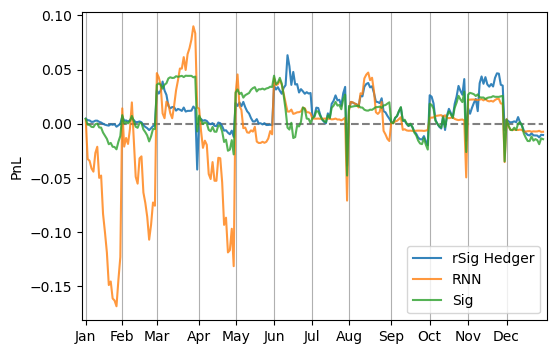

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.plot(
    np.zeros_like(np.concatenate(list(pnl_evolutions.values()))),
    linestyle="--",
    color="gray",
    linewidth=1.5,
)

ax1.plot(
    np.concatenate(list(pnl_evolutions.values())),
    linewidth=1.5,
    label="rSig Hedger",
    alpha=0.9,
)
#ax1.plot(
#    np.concatenate(list(delta_pnl_evolutions.values())),
#    linewidth=1.5,
#    label="Delta Hedge",
#    alpha=0.9,
#)
#ax1.plot(
#    np.concatenate(list(no_evolutions.values())),
#    linewidth=1.5,
#    label="No hedge",
#    alpha=0.5,
#)
ax1.plot(
    np.concatenate(list(deephedger_pnl_evolutions.values())),
    linewidth=1.5,
    label="RNN",
    alpha=0.8,
)
ax1.plot(np.concatenate(list(loaded_sigpl.values())),
    linewidth=1.5,
    label="Sig",
    alpha=0.8,
)
ax1.xaxis.grid(True)
# plt.grid(True)
plt.xticks(ticks=index, labels=months)
plt.xlim(left=-2, right=20 * 12)
plt.ylabel("PnL")
plt.legend()

In [ ]:
fig.savefig("/Users/fjiang/Downloads/pnl_evolution_sigvsrnn.png", bbox_inches="tight")

In [ ]:
# make dummy model
#loss_fn = QuadraticLoss(p0=22)
stock = RoughBergomiStock(
    hurst=0.05,
    rho=-0.837,
    eta=2.235,
    xi=0.05**2,
    cost=0,
    dt=1.0 / 365,
    forward_offset=15.0 / 365,
)
init_state = (100, stock.xi, None)

derivative = EuropeanOption(
    underlier=stock,
    call=True,
    strike=100,
    maturity=30.0 / 365,
)

vix = VIX(stock, maturity=30.0 / 365)
hedge = [derivative, vix]

model = SigHedger(
    derivative=derivative,
            inputs=inputs,
            hedge=hedge,
            criterion=loss_fn,
            signature_dim=6,
            n_attn_heads=n_attn_heads,
            n_attn_blocks=n_attn_blocks,
            order=1,
            #randomness= rho**2+hurst,
            rng_key=model_key,
)
simulated_data = model.derivative.simulate(rng_key= key, init_state= init_state)
#VIX(stock).price(simulated_data)
print(simulated_data["forward_variance"])
month = 4
df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
spx = df_month["SPX"].to_numpy()
vix = df_month["VIX"].to_numpy()
K = spx[0]
moneyness = spx / K
var_swap = vix / 100
print(var_swap)

[0.00250626 0.00229141 0.00253072 0.00223738 0.00213712 0.00200759
 0.00226861 0.0020737  0.00248044 0.00298585 0.00318511 0.00303926
 0.00242973 0.00258649 0.00300679 0.00291544 0.00230232 0.00231777
 0.00241697 0.00213921 0.00204233 0.00224343 0.00216783 0.00196288
 0.00199679 0.00191938 0.00194965 0.00216957 0.00170578 0.00183124]
[0.1963 0.1857 0.2103 0.221  0.2155 0.2116 0.2437 0.2426 0.2182 0.227
 0.2217 0.2137 0.2032 0.2268 0.2821 0.2702 0.3352 0.316  0.2999 0.334 ]


[0.1963 0.1857 0.2103 0.221  0.2155 0.2116 0.2437 0.2426 0.2182 0.227
 0.2217 0.2137 0.2032 0.2268 0.2821 0.2702 0.3352 0.316  0.2999 0.334 ]
